In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from wordcloud import WordCloud

import numpy as np
import seaborn as sns

from cities.utils.data_loader import ZoningDataset

smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 2000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:

residential = pd.read_csv(os.path.join(root, "data/minneapolis/sourced/residential_permits.csv"))

residential = residential.rename(columns={"parcel_id": "parcel",
                                           "YEAR": "year",
                                           "UNITS": "housing_units",
                                           "ACREAGE": "acreage",})

residential["parcel"] = pd.to_numeric(residential["parcel"], errors='coerce')
residential = residential.dropna(subset=["parcel"])
residential["parcel"] = residential["parcel"].astype(int)


residential["year"] = pd.to_numeric(residential["year"], errors='coerce')
residential['year'] = residential['year'].astype(int)




#TODO anything else to drop?
columns_to_drop = ['SDE_ID', 'CO_CODE', 'CTU_CODE', 'CTU_ID', 'COCTU_ID', 'CTU_NAME']
residential = residential.drop(columns=columns_to_drop)

print(residential.columns)


display(residential.head())

print(
residential.shape
)


residential['housing_units'] = residential['housing_units'].astype(int)





residential = residential[residential["year"] <= 2020]


Index(['parcel', 'year', 'TENURE', 'HOUSING_TY', 'HOUSING__1', 'RES_PERMIT',
       'ADDRESS', 'ZIP_CODE', 'ZIP_PLUS_4', 'NAME', 'BUILDINGS',
       'housing_units', 'AGE_RESTRI', 'MEMORY_CAR', 'ASSISTED', 'COM_OFF_RE',
       'acreage', 'SQF', 'PUBLIC_FUN', 'PERMIT_VAL', 'COMMUNITY_'],
      dtype='object')


,parcel,year,TENURE,HOUSING_TY,HOUSING__1,RES_PERMIT,ADDRESS,ZIP_CODE,ZIP_PLUS_4,NAME,...,housing_units,AGE_RESTRI,MEMORY_CAR,ASSISTED,COM_OFF_RE,acreage,SQF,PUBLIC_FUN,PERMIT_VAL,COMMUNITY_
0,2302924240095,2016,RNT,MF5,Multifamily (5 units or more),NU,10 2nd St SE,NaN,NaN,NaN,...,72.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,14158749.0,Urban Center
1,2302924320836,2016,OWN,MF5,Multifamily (5 units or more),TF,100 3rd Ave S,NaN,NaN,The Carlyle,...,1.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,250000.0,Urban Center
2,2202924410102,2016,RNT,MF5,Multifamily (5 units or more),NU,100 Hennepin Ave,NaN,NaN,NaN,...,156.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,31925920.0,Urban Center
3,3002923230134,2015,OWN,DTQ,"Duplex, triplex and quad",RM,1000 Essex St SE,NaN,NaN,NaN,...,4.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,351000.0,Urban Center
4,2402924310002,2010,RNT,MF5,Multifamily (5 units or more),NU,1000 University Ave SE,55414.0,NaN,FloCo Fusion,...,84.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,10811000.0,Urban Center


(4215, 21)


In [3]:


residential['census_tract'] = np.nan
display(residential.head())

years = sorted(residential['year'].unique().astype(int))
print(years)

,parcel,year,TENURE,HOUSING_TY,HOUSING__1,RES_PERMIT,ADDRESS,ZIP_CODE,ZIP_PLUS_4,NAME,...,AGE_RESTRI,MEMORY_CAR,ASSISTED,COM_OFF_RE,acreage,SQF,PUBLIC_FUN,PERMIT_VAL,COMMUNITY_,census_tract
0,2302924240095,2016,RNT,MF5,Multifamily (5 units or more),NU,10 2nd St SE,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,14158749.0,Urban Center,NaN
1,2302924320836,2016,OWN,MF5,Multifamily (5 units or more),TF,100 3rd Ave S,NaN,NaN,The Carlyle,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,250000.0,Urban Center,NaN
2,2202924410102,2016,RNT,MF5,Multifamily (5 units or more),NU,100 Hennepin Ave,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,31925920.0,Urban Center,NaN
3,3002923230134,2015,OWN,DTQ,"Duplex, triplex and quad",RM,1000 Essex St SE,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,351000.0,Urban Center,NaN
4,2402924310002,2010,RNT,MF5,Multifamily (5 units or more),NU,1000 University Ave SE,55414.0,NaN,FloCo Fusion,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,10811000.0,Urban Center,NaN


[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [4]:
for year in years:

    print(year)

    mapping_path = os.path.join(root,
        f"data/minneapolis/sourced/parcel_to_census_tract_mappings/parcel_to_census_tract_ids_{year}.csv")


    mapping_df = pd.read_csv(mapping_path)

    display(mapping_df.head())

    assert mapping_df['parcel_id'].dtype == residential['parcel'].dtype

    mapping_set = set(mapping_df['parcel_id'])
    residential_set = set(residential['parcel'])

    overlap = mapping_set.intersection(residential_set)
    overlap_ratio = len(overlap) / len(residential_set)
    print(f"overlap ratio for year {year}", overlap_ratio)

    residential_year = residential[residential['year'] == year]

    duplicate_parcels = mapping_df[mapping_df.duplicated('parcel_id', keep=False)]
    if len(duplicate_parcels)>0:
        print("duplicate_parels! will keep first!", duplicate_parcels)
        mapping_df = mapping_df.drop_duplicates(subset='parcel_id', keep='first')

    merged = residential_year.merge(mapping_df, how='left', left_on='parcel', right_on='parcel_id')

    merged.set_index(residential_year.index, inplace=True)

    merged['census_tract_id'] = pd.to_numeric(merged['census_tract_id'], errors='coerce')
    merged['parcel_id'] = pd.to_numeric(merged['parcel_id'], errors='coerce')

    merged['census_tract_id'] = merged['census_tract_id'].fillna(0).astype(int)
    merged['parcel_id'] = merged['parcel_id'].fillna(0).astype(int)


    residential.loc[residential['year'] == year, 'census_tract'] = merged['census_tract_id']

residential['census_tract'] = residential['census_tract'].astype(int)
residential.loc[residential['census_tract'] == 0,'census_tract'] = np.nan

print("ratio of parcels without identified tract", residential['census_tract'].isna().sum()/len(residential))


2009


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,702823320058,27053111100
2,2,702823320056,27053111100
3,3,802824110095,27053109100
4,4,802824110096,27053109100


overlap ratio for year 2009 0.9783464566929134
duplicate_parels! will keep first!         Unnamed: 0      parcel_id  census_tract_id
192            192  2602924320152      27053105400
193            193  2602924320153      27053105400
194            194  2602924320154      27053105400
204            204  3502924330189      27053126000
205            205  3502924330190      27053126000
233            233  1002824210201      27053109900
234            234  1002824210201      27053109900
116858      116858  2602924320152      27053105400
116859      116859  2602924320153      27053105400
116860      116860  2602924320154      27053105400
127814      127814  3502924330189      27053126000
127815      127815  3502924330190      27053126000
2010


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,702823320058,27053111100
2,2,702823320056,27053111100
3,3,2102924430108,27053104100
4,4,2102924430036,27053104100


overlap ratio for year 2010 0.978740157480315
2011


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,2102924420120,27053103400
2,2,3502924120092,27053106000
3,3,3502924120279,27053106000
4,4,3502924120277,27053106000


overlap ratio for year 2011 0.9755905511811024
2012


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,2802924220165,27053105100
4,4,3502924320169,27053126000


overlap ratio for year 2012 0.9724409448818898
2013


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,902924420203,27053101600
4,4,902924420198,27053101600


overlap ratio for year 2013 0.9543307086614173
duplicate_parels! will keep first!         Unnamed: 0      parcel_id  census_tract_id
53              53  1302924220092      27053102600
86              86  1502924140111      27053002400
87              87  1502924140110      27053002400
92              92  1902923440013      27053104000
79548        79548  1302924220092      27053102600
87806        87806  1502924140110      27053002400
87807        87807  1502924140111      27053002400
101913      101913  1902923440013      27053104000
2014


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,902924420203,27053101600
4,4,902924420198,27053101600


overlap ratio for year 2014 0.9547244094488189
2015


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,902924420203,27053101600
4,4,902924420198,27053101600


overlap ratio for year 2015 0.9480314960629921
2016


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,902924420203,27053101600
4,4,902924420198,27053101600


overlap ratio for year 2016 0.9393700787401574
2017


,Unnamed: 0,parcel_id,census_tract_id
0,0,1311821120005,27053000102
1,1,3502924230001,27053126000
2,2,202824230266,27053008400
3,3,902924420203,27053101600
4,4,902924420198,27053101600


overlap ratio for year 2017 0.9303149606299213
2018


,Unnamed: 0,parcel_id,census_tract_id
0,0,3602924440227,27053107400
1,1,3602924440226,27053107400
2,2,3602924440225,27053107400
3,3,3602924440224,27053107400
4,4,3602924440223,27053107400


overlap ratio for year 2018 0.8901574803149607
duplicate_parels! will keep first!         Unnamed: 0      parcel_id  census_tract_id
11              11  3602924440191      27053107400
12              12  3602924440191      27053107400
15              15  3602924440187      27053107400
16              16  3602924440187      27053107400
17              17  3602924440187      27053107400
...            ...            ...              ...
138713      138713   102824110028      27053108800
138714      138714   102824110028      27053108800
138715      138715   102824110028      27053108800
138733      138733   102824110007      27053108800
138734      138734   102824110007      27053108800

[19784 rows x 3 columns]
2019


,Unnamed: 0,parcel_id,census_tract_id
0,0,3602924440227,27053107400
1,1,3602924440226,27053107400
2,2,3602924440225,27053107400
3,3,3602924440224,27053107400
4,4,3602924440223,27053107400


overlap ratio for year 2019 0.9047244094488189
2020


,Unnamed: 0,parcel_id,census_tract_id
0,0,3602924440227,27053107400
1,1,3602924440226,27053107400
2,2,3602924440225,27053107400
3,3,3602924440224,27053107400
4,4,3602924440223,27053107400


overlap ratio for year 2020 0.8948818897637796
ratio of parcels without identified tract 0.015029522275899088


In [5]:
before = len(residential)
residential = residential.dropna(subset = ['census_tract'])
after = len(residential)
residential['census_tract'] = residential['census_tract'].astype(int)
print(f"dropped {before - after} from {before} rows as missing census tract")

display(residential['census_tract'].dtype)

print(residential.columns)

dropped 56 from 3726 rows as missing census tract


dtype('int64')

Index(['parcel', 'year', 'TENURE', 'HOUSING_TY', 'HOUSING__1', 'RES_PERMIT',
       'ADDRESS', 'ZIP_CODE', 'ZIP_PLUS_4', 'NAME', 'BUILDINGS',
       'housing_units', 'AGE_RESTRI', 'MEMORY_CAR', 'ASSISTED', 'COM_OFF_RE',
       'acreage', 'SQF', 'PUBLIC_FUN', 'PERMIT_VAL', 'COMMUNITY_',
       'census_tract'],
      dtype='object')


,census_tract,year,housing_units
0,27053103600,2016,72
1,27053126100,2016,1
2,27053126200,2016,156
3,27053104900,2015,4
4,27053003800,2010,84


unique census tracts 122


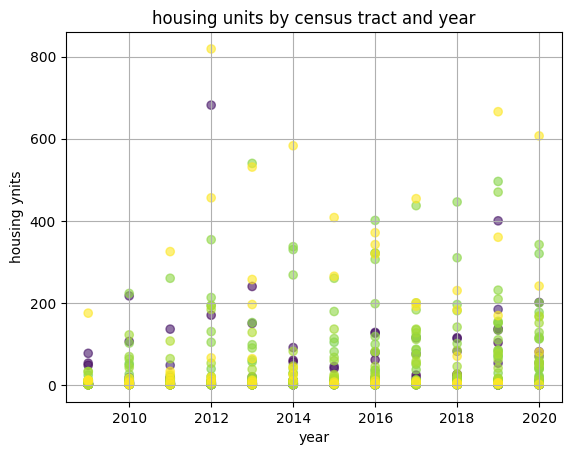

ratio of zeros 0.0040941658137154556


In [6]:
aggregadnum  = residential[['census_tract', 'year', 'housing_units']]

display(aggregadnum.head())

aggregated = aggregadnum.groupby(['census_tract', 'year']).sum().reset_index()

print("unique census tracts", len(aggregated['census_tract'].unique()))



plt.scatter(aggregated['year'], aggregated['housing_units'], 
                      c=aggregated['census_tract'].astype(int), cmap='viridis', alpha=0.6)

plt.title('housing units by census tract and year')
plt.xlabel('year')
plt.ylabel('housing ynits')
plt.grid(True)

# Show plot
plt.show()


# not too many zeros, this is promising
print("ratio of zeros",
(aggregated['housing_units']==0).sum()/len(aggregated)
)

census_tracts  = aggregated.copy()

In [7]:
values = pd.read_csv(os.path.join(root, "data/minneapolis/processed/values_long.csv"))

display(values.head())

,parcel,year,value,avg_value,applied,value_std,avg_value_std,parcel_id,year_id,census_tract
0,402924140049,2011,99500.0,104000.0,0,-0.103874,-0.106238,0,0,27053100400
1,1102924340022,2011,69300.0,68840.0,0,-0.118781,-0.123816,1,0,27053001700
2,202824230164,2011,157000.0,179200.0,0,-0.075492,-0.068641,2,0,27053008400
3,2102824210141,2011,242000.0,271250.0,0,-0.033536,-0.022621,3,0,27053111400
4,2702924241493,2011,144500.0,129600.0,0,-0.081662,-0.093439,5,0,27053105201


spearman correlation between total and median 0.675120583220817


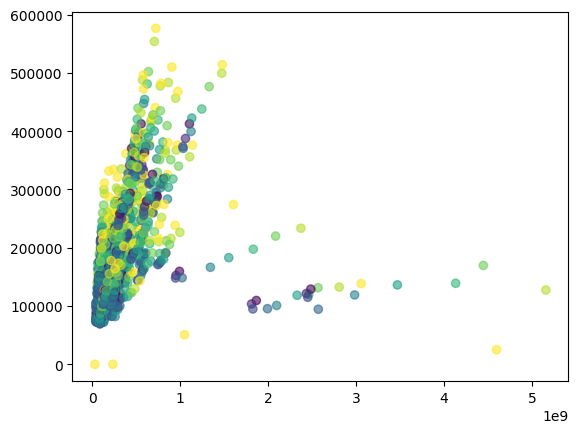

In [8]:
values = pd.read_csv(os.path.join(root, "data/minneapolis/processed/values_long.csv"))


aggregadnum  = values[['census_tract', 'year', 'value']]


aggregated_total = aggregadnum.groupby(['census_tract', 'year']).sum().reset_index()
aggregated_median = aggregadnum.groupby(['census_tract', 'year']).median().reset_index()

# rename columns
aggregated_total = aggregated_total.rename(columns={"value": "total_value"})
aggregated_median = aggregated_median.rename(columns={"value": "median_value"})

# check if no obvious connection between total and median
plt.scatter(x = aggregated_total['total_value'], y = aggregated_median['median_value'], 
                      c=aggregated_total['year'].astype(int), cmap='viridis', alpha=0.6)

#spearman correlation
correlation = aggregated_total['total_value'].corr(aggregated_median['median_value'], method='spearman')
print("spearman correlation between total and median", correlation)

In [9]:
display(census_tracts.head())
census_tracts = census_tracts.merge(aggregated_total, on=['census_tract', 'year'])
census_tracts = census_tracts.merge(aggregated_median, on=['census_tract', 'year'])
display(census_tracts.head())

assert census_tracts['total_value'].isna().sum() == 0
assert census_tracts['median_value'].isna().sum() == 0

,census_tract,year,housing_units
0,27053000101,2009,2
1,27053000101,2010,2
2,27053000101,2011,1
3,27053000101,2013,5
4,27053000101,2018,2


,census_tract,year,housing_units,total_value,median_value
0,27053000101,2011,1,150058700.0,112000.0
1,27053000101,2013,5,139303800.0,104000.0
2,27053000101,2018,2,201663000.0,137000.0
3,27053000101,2019,1,220227900.0,151500.0
4,27053000102,2011,5,204521700.0,99500.0
